In [1]:
%matplotlib inline

In [2]:
import sys
#print (sys.getdefaultencoding())

In [3]:
from __future__ import unicode_literals, print_function, division
import unicodedata
from io import open
import random
import re

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
print(use_cuda)
torch.cuda.set_device(3)

True


In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [5]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        if self.name == "chn":
            for word in sentence:
                self.addWord(word)
            return
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    #s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    #lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
    #    read().strip().split('\n')
        
    lines1 = open('data/%s.txt' % (lang1), encoding = 'utf-8').read().strip().split('\n')
    lines2 = open('data/%s.txt' % (lang2), encoding = 'utf-8').read().strip().split('\n')
    # Split every line into pairs and normalize
    #pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    #pairs = [[s for s in l.split('\t')] for l in lines]
    pairs = [[normalizeString(lines1[i]), normalizeString(lines2[i]) ] for i in xrange(min(len(lines1), len(lines2)))]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    #pairs = [[s for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [9]:
MAX_LENGTH = 1000

In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    #pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    #print(input_lang.name, input_lang.n_words, input_lang.word2count)
    #print(output_lang.name, output_lang.n_words, output_lang.word2count)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'chn', True)
for i in random.choice(pairs):
    print(i)
print(random.choice(pairs))

Reading lines...
Read 18167 sentence pairs
Trimmed to 18167 sentence pairs
Counting words...
Counted words:
我得要在一週內回家。
I must return home within a week .
[u'\u522b\u518d\u50bb\u770b\u7740\u3002', u'Stop gawking .']


In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [13]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
   

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    
    decoder_hidden = encoder_hidden

    #use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    use_teacher_forcing = False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            
            loss += criterion(decoder_output[0], target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
def indexesFromSentence(lang, sentence):
    if lang.name == "chn":
        return [lang.word2index[word] for word in sentence]
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [16]:
def trainEpochs(encoder, decoder, n_epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_epochs)]
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        training_pair = training_pairs[epoch - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
        '''
        if epoch%1000 == 1: 
            print(epoch)
            print(input_variable)
            print(target_variable)
        '''    
        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                         epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

7m 9s (- 100m 16s) (5000 6%) 4.7359
14m 42s (- 95m 35s) (10000 13%) 4.5348
22m 15s (- 89m 1s) (15000 20%) 4.2354
30m 35s (- 84m 6s) (20000 26%) 3.9680
38m 58s (- 77m 56s) (25000 33%) 3.7268
47m 37s (- 71m 25s) (30000 40%) 3.5258
55m 26s (- 63m 21s) (35000 46%) 3.3840
62m 44s (- 54m 53s) (40000 53%) 3.2113
69m 59s (- 46m 39s) (45000 60%) 3.1044
78m 17s (- 39m 8s) (50000 66%) 2.9941
86m 33s (- 31m 28s) (55000 73%) 2.8967
94m 18s (- 23m 34s) (60000 80%) 2.8071
102m 20s (- 15m 44s) (65000 86%) 2.7073
110m 46s (- 7m 54s) (70000 93%) 2.6756
118m 52s (- 0m 0s) (75000 100%) 2.6059


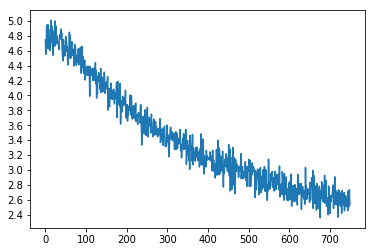

In [17]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               1, dropout_p=0.1)

if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()
    
trainEpochs(encoder1, attn_decoder1, 75000, print_every=5000)

In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
        
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [20]:
evaluateRandomly(encoder1, attn_decoder1)

> 她很容易受到感情上的伤害。
= Her feelings are easily hurt .
< She was hurt hurt . . <EOS>

> 那是我真的很喜歡的椅子。
= That's the chair that I really like .
< That's was chair like really . <EOS>

> 你說的沒有道理。
= What you said does not make sense .
< What aren't not not sense sense <EOS>

> 我们要建立避难所。
= We're going to set up shelters .
< We're going to to do do . <EOS>

> 我怕死。
= I am afraid of death .
< I am afraid of . <EOS>

> 你该戒烟戒酒了。
= You should give up smoking and drinking .
< You should have smoking smoking <EOS>

> 我不想去那儿，他也不想。
= I don't want to go there . He doesn't want to go either .
< I don't want to do didn't do he . <EOS>

> 這間動物園多久了？
= How old is this zoo ?
< How long is the ? ? ? <EOS>

> 许多人在工业城市工作。
= Many people work in industrial towns .
< Many people people people in in . <EOS>

> 你週末有什麼計劃？
= What're your plans for the weekend ?
< What are your plans weekend weekend ? <EOS>



In [23]:
PATH = "./encoder.pt"
torch.save(encoder1, PATH)

/home/huangchao/venv/local/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [24]:
PATH = "./decoder.pt"
torch.save(attn_decoder1, PATH)

/home/huangchao/venv/local/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type AttnDecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


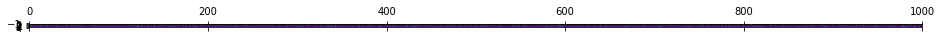

In [25]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "你好吗")
plt.matshow(attentions.numpy())